In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#loading images
images_train = np.load('train_images.npy',encoding="latin1")
print ("train images shape: ",images_train.shape)

#loading labels
train_labels= np.genfromtxt("train_labels.csv", names =True, delimiter =',',
                           dtype=[('Id','i8'),('Category','S5')])
print('train labels shape: ',train_labels.shape)

train images shape:  (10000, 2)
train labels shape:  (10000,)


# Fonctions

Si on a une image 100X100 (image1), il suffit de rouler resize dessus pour produire en sortie un recadrage 40X40.
Les 2 autres fonctions sont des helpers

In [40]:
def PixelDensity(image):
    """ Clean an image by keeping only groups of pixels over a threshold density
        First step : Create density groups"""
    
    test1 = (image>0) * np.ones((100,100))
    built1 = np.zeros(test1.shape)
    built1[0]  = test1[0]
    for line in range(1,len(test1)):
        built1[line]=test1[line]
        if built1[line][0] > 0 : built1[line][0] += max(built1[line-1][:2])
        for i in range(1,99):
            if built1[line][i]>0:
                built1[line][i] += max(built1[line-1][i-1:i+2])
        if built1[line][-1]>0 : built1[line][-1]+= max(built1[line-1][-2:])

    flip = test1.transpose()
    built2 = np.zeros(flip.shape)
    built2[0] = flip[0]
    for line in range(1,len(flip)):
        built2[line]=flip[line]
        if built2[line][0] >0 : built2[line][0] += max(built2[line-1][:2])
        for i in range(1,99):
            if built2[line][i]>0:
                built2[line][i] += max(built2[line-1][i-1:i+2])
        if built2[line][-1]>0 : built2[line][-1]  += max(built2[line-1][-2:])

    built1 = built1 + built2.transpose()

    n=0
    while n<10:

        #propagate back
        for line in range(-2,-len(test1),-1):
            if built1[line][0] > 0 : built1[line][0] = (np.maximum(built1[line][:2],built1[line+1][:2])).max()
            for i in range(1,99):
                if built1[line][i] >0 :
                    built1[line][i] = (np.maximum(built1[line][i-1:i+2],built1[line+1][i-1:i+2])).max()
            if built1[line][-1]>0 : built1[line][-1] = (np.maximum(built1[line][-2:],built1[line+1][-2:])).max()

        for line in range(1,len(test1)):
            if built1[line][0] > 0 : built1[line][0] = (np.maximum(built1[line][:2],built1[line-1][:2])).max()
            for i in range(1,99):
                if built1[line][i] >0 :
                    built1[line][i] = (np.maximum(built1[line][i-1:i+2],built1[line-1][i-1:i+2])).max()
            if built1[line][-1]>0 : built1[line][-1] = (np.maximum(built1[line][-2:],built1[line-1][-2:])).max()

        n +=1

    #plt.imshow(built1)        #remnants of testing
    #plt.show()

    #propagate back transpose                           Remnants
    """
    for line in range(-2,-len(flip),-1):
        if built2[line][0] > 0 : built2[line][0] = (np.maximum(built2[line][0],built2[line+1][0])).max()
        for i in range(1,99):
            if built2[line][i] >0 :
                built2[line][i] = (np.maximum(built2[line][i],built2[line+1][i])).max()
        if built2[line][-1]>0 : built2[line][-1] = (np.maximum(built2[line][-1],built2[line-1][-1])).max()"""
        
    return built1

def threshold(builder,param):
    """ Setting the threshold and cleaning the image"""
    
    clean = (builder > param)*builder
    return clean

# Ok, now it is time to reshape around the image to keep as much details as we can:
# Note : They all seem to fit inside 40X40

def resize(image):
    """ function trying to resize around relevant data """
    
    build = PixelDensity(image)
    ladder = build.max()
    to_project = threshold(build,ladder-4)
    
    project_x = to_project.sum(axis=0)
    project_y = to_project.sum(axis=1)
    
    inds_x = np.nonzero(project_x)[0]
    inds_y = np.nonzero(project_y)[0]
    
    
    off =0                                # off >0 plante pour des pixels proche de la frontière
                                                #anyway,non-nécessaire. laisser à 0
        
    if (inds_x[-1]-inds_x[0])>39: inds_x[-1]= (inds_x[0]+39) 
    if (inds_y[-1]-inds_y[0])>39: inds_y[-1]= (inds_y[0]+39) 
    
    crop = image[inds_y[0]-off:inds_y[-1]+off+1,inds_x[0]-off:inds_x[-1]+off+1]
    centered = np.zeros((40,40))
    x_off = (40-crop.shape[1])//2
    y_off = (40-crop.shape[0])//2
    
    centered[y_off:crop.shape[0]+y_off,x_off:crop.shape[1]+x_off] = crop
    
    return centered

## Exemple:

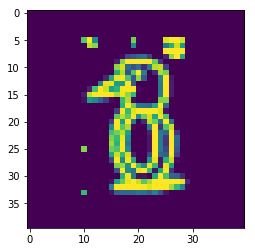

In [43]:
tester = (images_train[119][1]).reshape(100,100)

recadrage = resize(tester)
plt.imshow(recadrage)

## Processing them all

Okay, maintenant on va process tout le train set et tout le test set:

In [44]:
# train set

to_store = np.zeros((10000,2),dtype=np.ndarray)

for i in range(10000):
    to_store[i][0] = images_train[i][0]
    to_store[i][1] = (resize(images_train[i][1].reshape(100,100)))
    
    if i%200 == 0 : print(str(i)+" images de process")
        
np.save("Processed_train_images.npy",to_store)

0 images de process
200 images de process
400 images de process
600 images de process
800 images de process
1000 images de process
1200 images de process
1400 images de process
1600 images de process
1800 images de process
2000 images de process
2200 images de process
2400 images de process
2600 images de process
2800 images de process
3000 images de process
3200 images de process
3400 images de process
3600 images de process
3800 images de process
4000 images de process
4200 images de process
4400 images de process
4600 images de process
4800 images de process
5000 images de process
5200 images de process
5400 images de process
5600 images de process
5800 images de process
6000 images de process
6200 images de process
6400 images de process
6600 images de process
6800 images de process
7000 images de process
7200 images de process
7400 images de process
7600 images de process
7800 images de process
8000 images de process
8200 images de process
8400 images de process
8600 images de pro

In [46]:
# Trying le loading des nouvelles donnés
#loading images
new_images_train = np.load('Processed_train_images.npy')
print ("train images shape: ",new_images_train.shape)

train images shape:  (10000, 2)


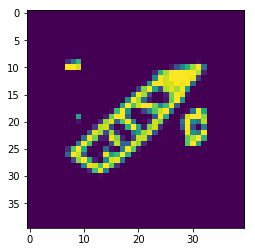

In [47]:
ddata = new_images_train[9999][1].reshape(40,40)
plt.imshow(ddata)

In [51]:
# Même chose mais pour le test set
#loading images
images_test = np.load('test_images.npy',encoding="latin1")
print ("test images shape: ",images_test.shape)

test images shape:  (10000, 2)


In [52]:
# test set

to_store2 = np.zeros((10000,2),dtype=np.ndarray)

for i in range(10000):
    to_store2[i][0] = images_test[i][0]
    to_store2[i][1] = (resize(images_test[i][1].reshape(100,100)))
    
    if i%200 == 0 : print(str(i)+" images de process")
        
np.save("Processed_test_images.npy",to_store2)

0 images de process
200 images de process
400 images de process
600 images de process
800 images de process
1000 images de process
1200 images de process
1400 images de process
1600 images de process
1800 images de process
2000 images de process
2200 images de process
2400 images de process
2600 images de process
2800 images de process
3000 images de process
3200 images de process
3400 images de process
3600 images de process
3800 images de process
4000 images de process
4200 images de process
4400 images de process
4600 images de process
4800 images de process
5000 images de process
5200 images de process
5400 images de process
5600 images de process
5800 images de process
6000 images de process
6200 images de process
6400 images de process
6600 images de process
6800 images de process
7000 images de process
7200 images de process
7400 images de process
7600 images de process
7800 images de process
8000 images de process
8200 images de process
8400 images de process
8600 images de pro

In [53]:
# Trying le loading des nouvelles donnés
#loading images
new_images_test = np.load('Processed_test_images.npy')
print ("test images shape: ",new_images_test.shape)

test images shape:  (10000, 2)


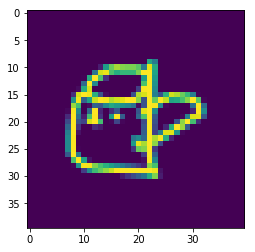

In [54]:
dddata = new_images_test[9999][1].reshape(40,40)
plt.imshow(dddata)